In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Install TensorFlow if needed
!pip install tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# --- Load data ---
df = pd.read_csv("https://raw.githubusercontent.com/yanhanBazoooka/DS3001_project/refs/heads/main/DATA/sleep_cycle_productivity.csv")

# --- Feature Engineering ---
# 1. Sleep consistency
sleep_consistency = df.groupby('Person_ID')['Total Sleep Hours'].std().rename("Sleep Consistency")
df = df.merge(sleep_consistency, on="Person_ID")

# 2. Sleep efficiency
df["Sleep Duration Window"] = (df["Sleep End Time"] - df["Sleep Start Time"]) % 24
df["Sleep Efficiency"] = df["Total Sleep Hours"] / df["Sleep Duration Window"]

# 3. Evening screen ratio
df["Evening Screen Ratio"] = df["Screen Time Before Bed (mins)"] / (df["Sleep Duration Window"] * 60)

# Drop intermediate columns
df = df.drop(columns=["Sleep Duration Window"])

# --- Handle categorical and numeric features ---
categorical_features = ["Gender"]
numerical_features = df.select_dtypes(include=["number"]).drop(columns=["Person_ID"]).columns.tolist()

# Handle multicollinearity: drop highly correlated features
corr_matrix = df[numerical_features].corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.8)]
df_reduced = df.drop(columns=to_drop)

# --- Standardization ---
final_numeric = df_reduced.select_dtypes(include=["number"]).drop(columns=["Person_ID"]).columns
scaler = StandardScaler()
df_scaled = df_reduced.copy()
df_scaled[final_numeric] = scaler.fit_transform(df_reduced[final_numeric])

# --- Prepare X, y ---
exclude_cols = ["Person_ID", "Date"]
X = df_scaled.drop(columns=exclude_cols + ["Productivity Score"], errors='ignore')
y = df_scaled["Productivity Score"]

# Remove object/datetime columns just in case
X = X.select_dtypes(include=[np.number])

# Drop missing values
Xy = pd.concat([X, y], axis=1).dropna()
X = Xy.drop(columns=["Productivity Score"])
y = Xy["Productivity Score"]

# --- Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

# --- Feature Selection: LASSO ---
lasso = LassoCV(cv=5, random_state=50)
lasso.fit(X_train, y_train)
lasso_selected_features = X.columns[(lasso.coef_ != 0)].tolist()

# --- Dimensionality Reduction: PCA ---
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X)

# New dataframe with principal components
pca_columns = [f"PC{i+1}" for i in range(X_pca.shape[1])]
df_pca = pd.DataFrame(X_pca, columns=pca_columns)
df_pca["Productivity Score"] = y.values

# Split again after PCA
X = df_pca.drop(columns=["Productivity Score"])
y = df_pca["Productivity Score"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

# --- Models: Linear Regression, Decision Tree, kNN, ANN ---
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(max_depth=5, random_state=50),
    "kNN": KNeighborsRegressor(n_neighbors=5)
}

# --- Train and Evaluate Traditional Models ---
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(f"\n{name}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test, preds)):.4f}")
    print(f"MAE: {mean_absolute_error(y_test, preds):.4f}")
    print(f"R^2: {r2_score(y_test, preds):.4f}")

# --- Build and Train ANN ---
model_ann = Sequential([
    Dense(64, activation='relu', input_shape=(X.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])

model_ann.compile(optimizer='adam', loss='mse', metrics=['mae'])
model_ann.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate ANN
ann_preds = model_ann.predict(X_test).flatten()
print("\nArtificial Neural Network")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, ann_preds)):.4f}")
print(f"MAE: {mean_absolute_error(y_test, ann_preds):.4f}")
print(f"R^2: {r2_score(y_test, ann_preds):.4f}")

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2485063603769504, tolerance: 0.1347958848368591
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9525783038131976, tolerance: 0.1347958848368591
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.155918541512847, tolerance: 0.1347958848368591
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: Convergen


Linear Regression
RMSE: 1.0165
MAE: 0.8832
R^2: -0.0092

Decision Tree
RMSE: 1.0406
MAE: 0.8940
R^2: -0.0577

kNN
RMSE: 1.0776
MAE: 0.9136
R^2: -0.1343
Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.0984 - mae: 0.8951 - val_loss: 1.0273 - val_mae: 0.8567
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0162 - mae: 0.8757 - val_loss: 1.0183 - val_mae: 0.8579
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0373 - mae: 0.8937 - val_loss: 1.0178 - val_mae: 0.8539
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9821 - mae: 0.8645 - val_loss: 1.0240 - val_mae: 0.8557
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9724 - mae: 0.8626 - val_loss: 1.0217 - val_mae: 0.8539
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9309 - mae: 0.8426 - val_loss: 1.0212 - val_mae: 0.8517
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9359 - mae: 0.8348 - val_loss: 1.0133 - val_mae: 0.8514
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━

The model provides a coarse estimate of productivity, but its predictive power is limited. further progress likely requires richer or more subjective data.
still, the pipeline demonstrates an end-to-end architecture from raw behavioral data to interpretable prediction.

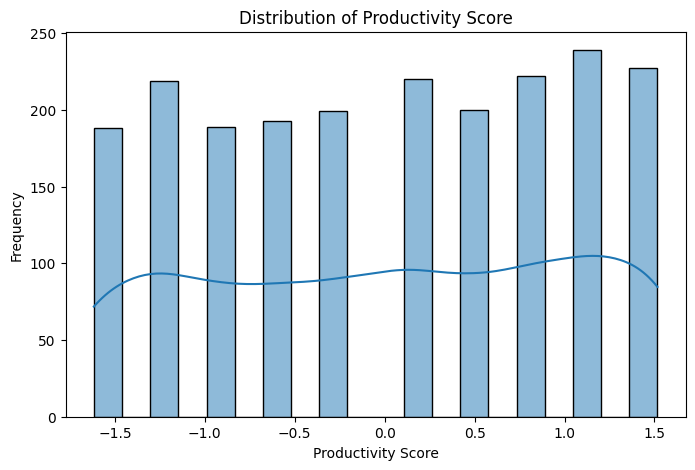

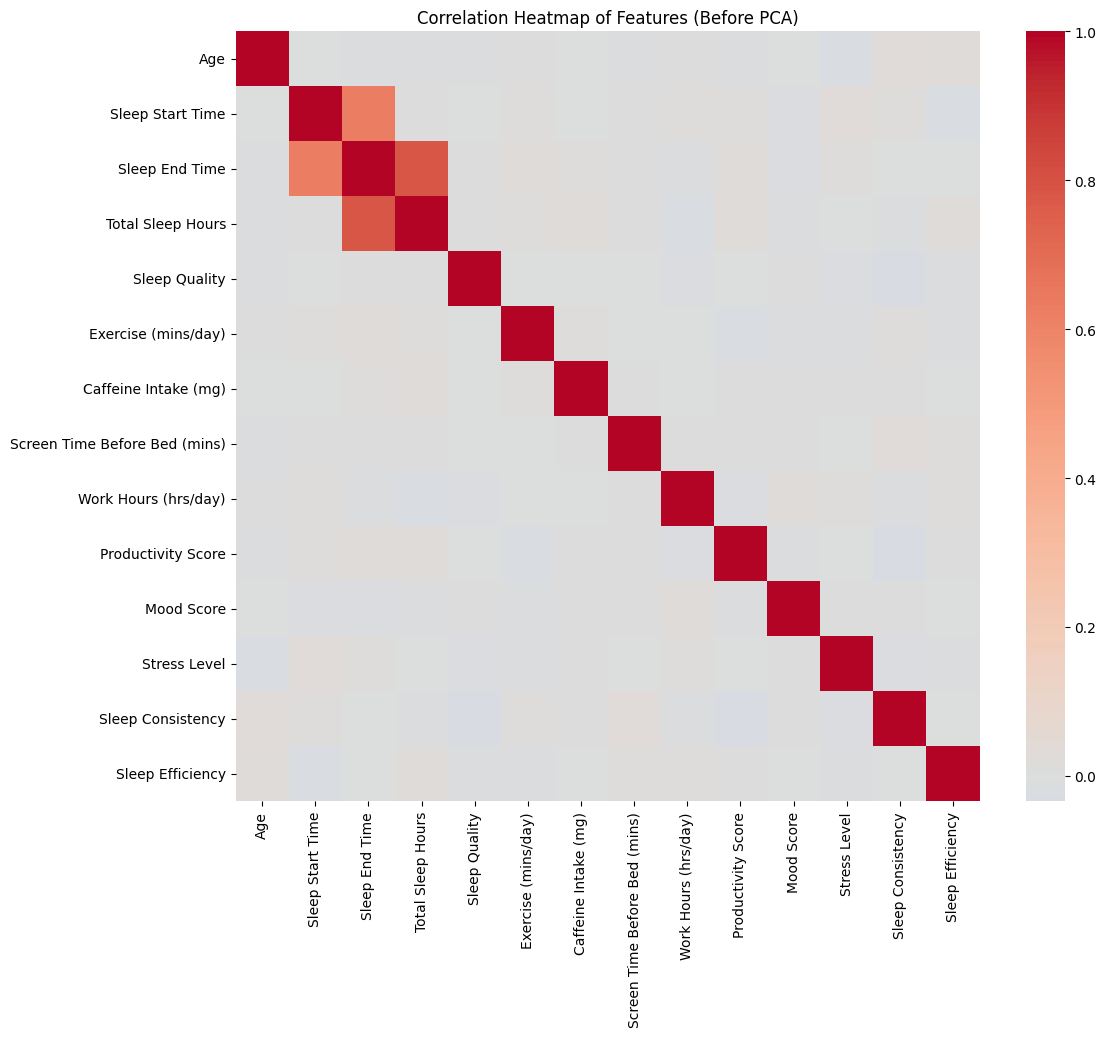

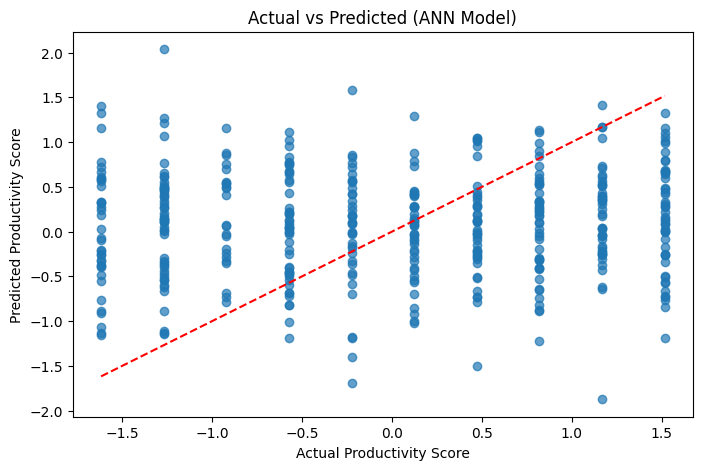

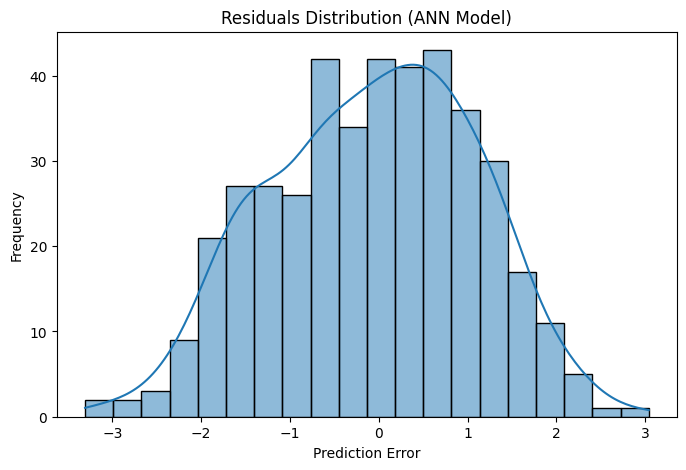

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Distribution of Productivity Score ---
plt.figure(figsize=(8, 5))
sns.histplot(y, bins=20, kde=True)
plt.title('Distribution of Productivity Score')
plt.xlabel('Productivity Score')
plt.ylabel('Frequency')
plt.show()

# --- 2. Correlation Heatmap Before PCA ---
# Drop non-numeric columns first
numeric_df = df_scaled.select_dtypes(include=[np.number]).drop(columns=["Person_ID"], errors='ignore')

plt.figure(figsize=(12, 10))
corr = numeric_df.corr()
sns.heatmap(corr, annot=False, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Features (Before PCA)')
plt.show()

# --- 3. Actual vs Predicted: ANN Model ---
plt.figure(figsize=(8, 5))
plt.scatter(y_test, ann_preds, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Productivity Score')
plt.ylabel('Predicted Productivity Score')
plt.title('Actual vs Predicted (ANN Model)')
plt.show()

# --- 4. Residuals Distribution: ANN Model ---
residuals = y_test - ann_preds
plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=20, kde=True)
plt.title('Residuals Distribution (ANN Model)')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.show()

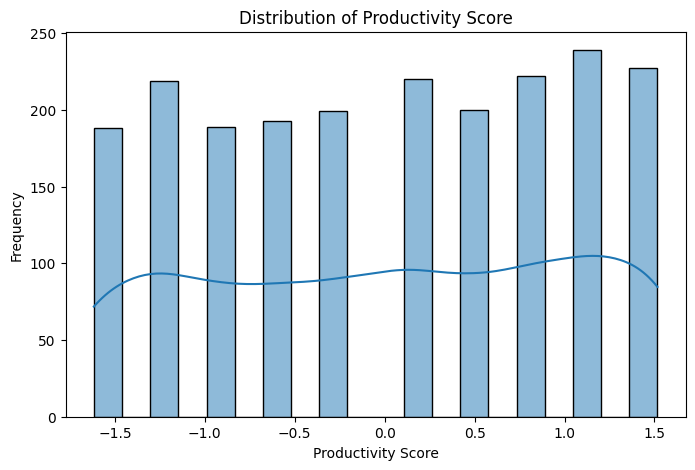

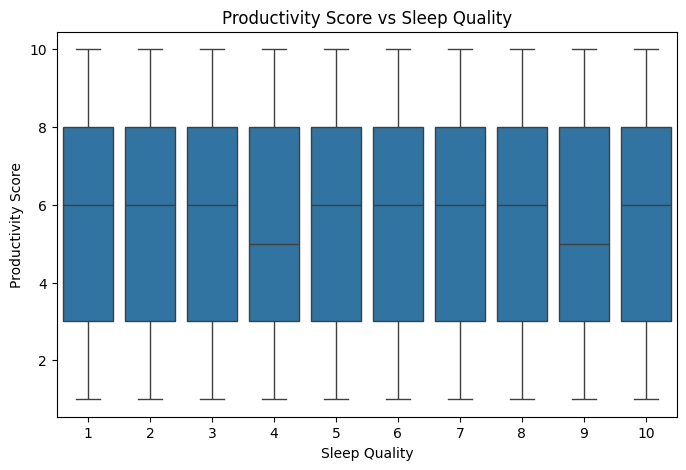

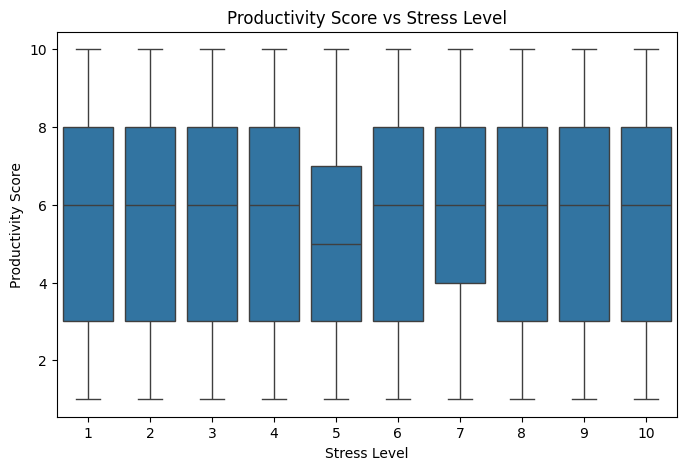

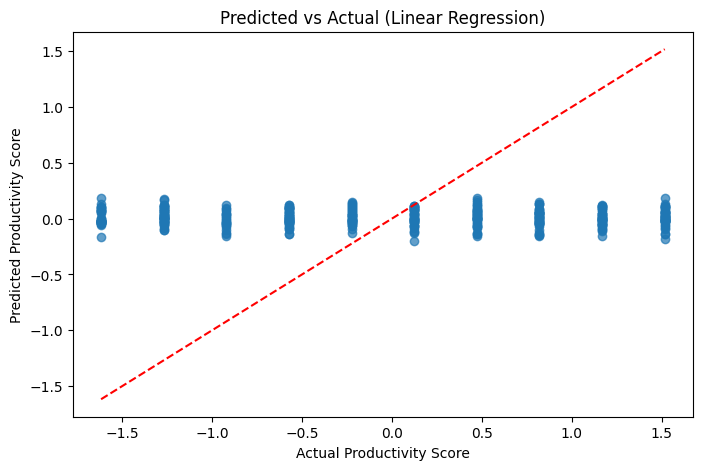

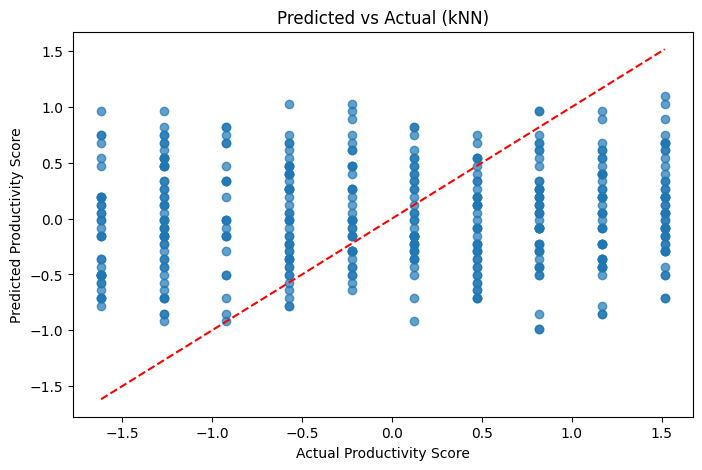

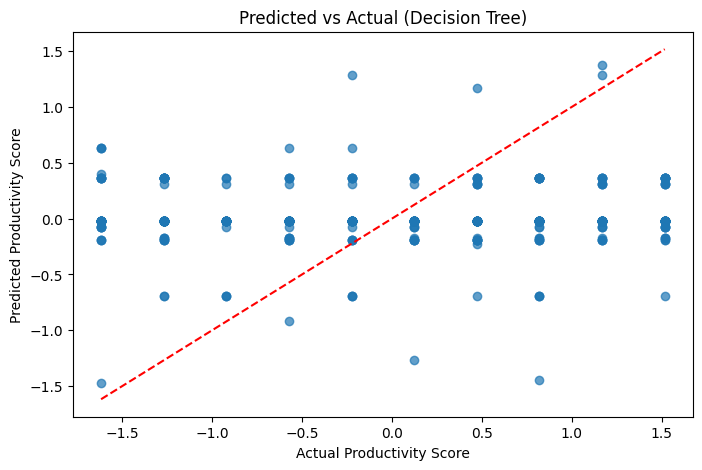

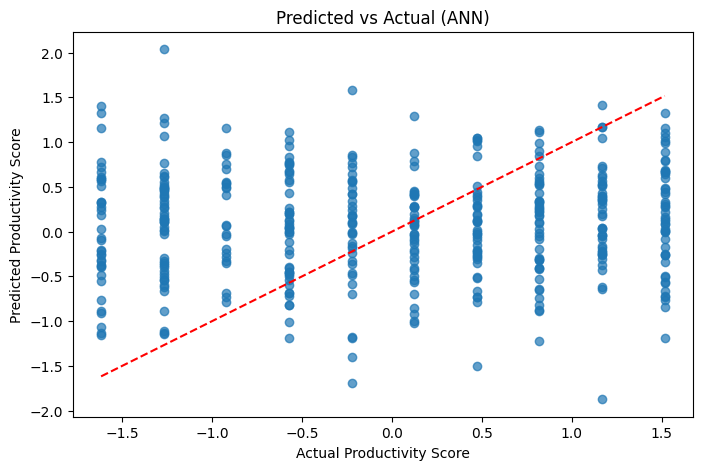

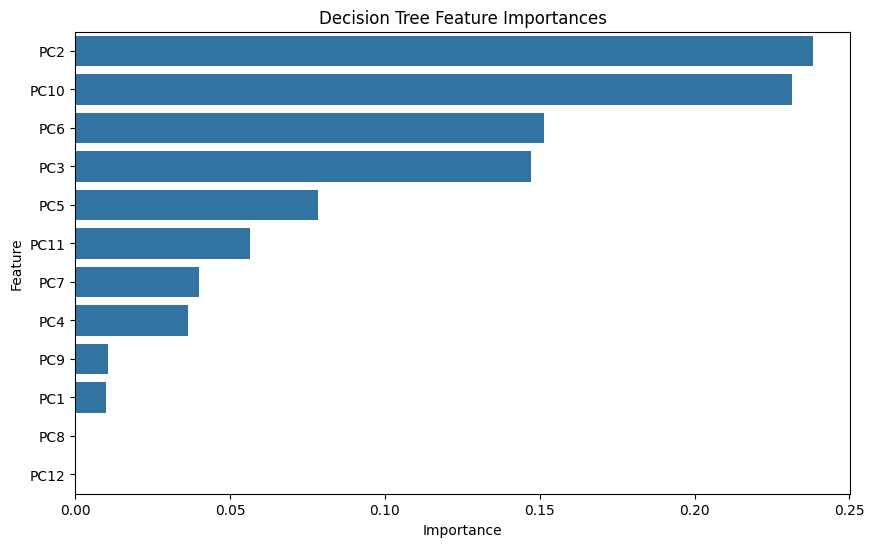

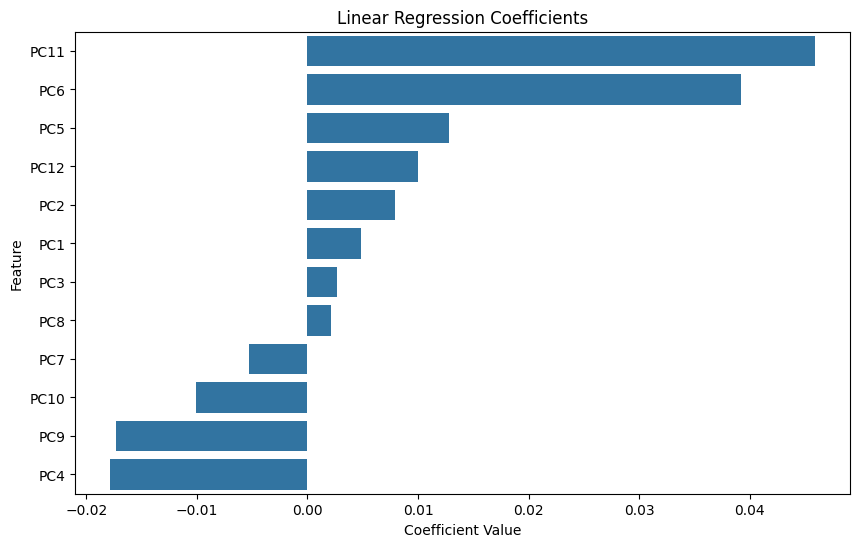

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Graph 1 Histogram:  Distribution of Productivity Score
plt.figure(figsize=(8, 5))
sns.histplot(y, bins=20, kde=True)  # KDE = smooth curve
plt.title('Distribution of Productivity Score')
plt.xlabel('Productivity Score')
plt.ylabel('Frequency')
plt.show()

# Graph 2 & 3 Boxplots: 'Sleep Quality' VS 'Productivity Score', 'Stress Level' VS 'Productivity Score'

features_to_plot = ['Sleep Quality', 'Stress Level']

for feature in features_to_plot:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=df_reduced[feature], y=df_reduced['Productivity Score'])
    plt.title(f'Productivity Score vs {feature}')
    plt.xlabel(feature)
    plt.ylabel('Productivity Score')
    plt.show()

# Graph 4, 5, 6, 7: Scatterplot Predicted vs Actual (for Linear, kNN, Tree, ANN)
linear_preds = models['Linear Regression'].predict(X_test)
tree_preds = models['Decision Tree'].predict(X_test)
knn_preds = models['kNN'].predict(X_test)

def plot_predicted_vs_actual(y_true, y_pred, title):
    plt.figure(figsize=(8, 5))
    plt.scatter(y_true, y_pred, alpha=0.7)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')  # Reference line y=x
    plt.xlabel('Actual Productivity Score')
    plt.ylabel('Predicted Productivity Score')
    plt.title(title)
    plt.show()

# Plot for each model
plot_predicted_vs_actual(y_test, linear_preds, 'Predicted vs Actual (Linear Regression)')
plot_predicted_vs_actual(y_test, knn_preds, 'Predicted vs Actual (kNN)')
plot_predicted_vs_actual(y_test, tree_preds, 'Predicted vs Actual (Decision Tree)')
plot_predicted_vs_actual(y_test, ann_preds, 'Predicted vs Actual (ANN)')


# Graph 8 Barplot: Decision Tree Feature Importances
tree_importances = models['Decision Tree'].feature_importances_


tree_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': tree_importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=tree_importance_df)
plt.title('Decision Tree Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Graph 9 Barplot:  Linear Regression Coefficients
linear_coefficients = models['Linear Regression'].coef_

linear_coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': linear_coefficients
}).sort_values(by='Coefficient', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=linear_coef_df)
plt.title('Linear Regression Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()

